# Pipeline for the anomaly detection on the SKAB using MSET

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [3]:
# libraries importing
import math
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


sys.path.append("..")
from core.MSET import MSET
from core.metrics import chp_score
from core.utils import plot_results

sys.path.append("../../odmd-subid-cpd")
from functions.datasets import load_cats

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [4]:
df = load_cats(
    file_path="/Users/mw/pyprojects/odmd-subid-cpd/examples/data/cats/data.csv",
    resample_s=60,
)
df = df.rename(columns={"y": "anomaly"})
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
        "aimp",
        "amud",
        "adbr",
        "adfl",
    ]
]
Y = df[["anomaly", "category"]]
Xy_traintest_list = [
    train_test_split(
        X,
        Y,
        train_size=int(1e6 / 60),
        shuffle=False,
        random_state=0,
    )
]

## Method

### Method initialization

In [5]:
def movmean(array, window):
    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan] * window, i))
    y = np.nanmean(y, axis=0)
    window_ceil = math.ceil(window / 2)

    return y[window_ceil - 1 : n + window_ceil - 1]

### Method fitting and applying

In [6]:
# inference
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []
rel_errors = []
x = 0
for X_train, X_test, y_train, y_test in Xy_traintest_list:
    x += 1

    model = MSET()
    model.fit(X_train)

    # results predicting
    Y_pred = model.predict(X_test)
    err = np.linalg.norm(X_test - Y_pred, axis=1)
    rel_err = movmean(err / np.linalg.norm(Y_pred, axis=1), window=60)
    rel_errors.append(rel_err)

    UCL = 0.01
    prediction = (
        pd.DataFrame((rel_err > UCL), X_test.index)
        .fillna(0)
        .any(axis=1)
        .astype(int)
    )

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(y_test["anomaly"])
    true_cp.append(y_test["anomaly"].diff().abs().fillna(0.0))

2024-05-20 15:19:52.605096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/9t/kc1m3g417jn3cxcthd05f6l40000gn/T/ipykernel_19302/237449712.py:7: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=0)


### Results visualization

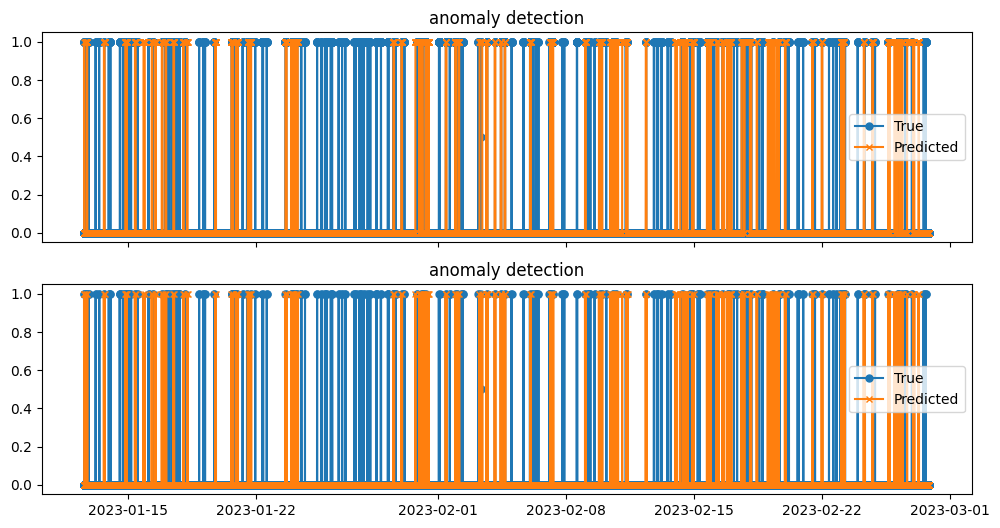

In [7]:
# [donotremove]
plot_results(
    (true_outlier[0], predicted_outlier[0]),
    (true_cp[0], predicted_cp[0]),
)

## Evaluation (metrics calculation)

In [8]:
import pickle

pickle.dump(
    predicted_outlier,
    open(f"../results/results-cats-{model.__class__.__name__}.pkl", "wb"),
)

### Binary classification (outlier detection) metrics

In [9]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 11.32 %
Missing Alarm Rate 54.54 %
F1 metric 0.24


### Changepoint detection metrics

In [10]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Amount of true anomalies 398
A number of missed CPs = 327
A number of FPs = 58
Average time 0 days 01:03:24.507042253


In [11]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="18000s",
    anomaly_window_destination="righter",
)

Standard  -  14.48
LowFP  -  13.43
LowFN  -  15.6
